Reading and Preprocessing the data: 

In [1]:
def read_category_file(file_path):
    with open(file_path, 'r') as file:
        next(file) 
        id_to_name = {}
        for line in file:
            id, name = line.strip().split('\t')
            id = int(id)
            id_to_name[id-1] = name  
    return id_to_name

id_to_name_mapping = read_category_file('data/category.txt')

FileNotFoundError: [Errno 2] No such file or directory: 'data/category.txt'

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def create_image_data_generator(data, image_size=(150, 150), batch_size=32):
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=5,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        fill_mode='nearest',
        validation_split=0.2 
    )

    validation_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2
    )

    train_generator = train_datagen.flow_from_directory(
        data, 
        target_size=image_size,
        batch_size=batch_size,
        class_mode='sparse',
        subset='training' 
    )

    validation_generator = validation_datagen.flow_from_directory(
        data,  
        target_size=image_size,
        batch_size=batch_size,
        class_mode='sparse',
        subset='validation' 
    )
    return train_generator, validation_generator

train_gen, val_gen = create_image_data_generator('data')


ModuleNotFoundError: No module named 'tensorflow'

Building the Model

In [195]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import ( Conv2D, MaxPooling2D, Input,
    Concatenate, Flatten, Dense, Dropout,
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam


# def inception_module(x, reg_factor=0.01):
#     # 1x1 convolutions
#     conv1x1_1 = Conv2D(64, (1, 1), padding='same', kernel_regularizer=l2(reg_factor))(x)
#     conv1x1_1 = BatchNormalization()(conv1x1_1)
#     conv1x1_1 = Activation('relu')(conv1x1_1)
# 
#     conv1x1_2 = Conv2D(96, (1, 1), padding='same', kernel_regularizer=l2(reg_factor))(x)
#     conv1x1_2 = BatchNormalization()(conv1x1_2)
#     conv1x1_2 = Activation('relu')(conv1x1_2)
# 
#     conv1x1_3 = Conv2D(16, (1, 1), padding='same', kernel_regularizer=l2(reg_factor))(x)
#     conv1x1_3 = BatchNormalization()(conv1x1_3)
#     conv1x1_3 = Activation('relu')(conv1x1_3)
# 
#     # 3x3 convolution
#     conv3x3 = Conv2D(32, (3, 3), padding='same', kernel_regularizer=l2(reg_factor))(conv1x1_2)
#     conv3x3 = BatchNormalization()(conv3x3)
#     conv3x3 = Activation('relu')(conv3x3)
# 
#     # 5x5 convolution
#     conv5x5 = Conv2D(128, (5, 5), padding='same', kernel_regularizer=l2(reg_factor))(conv1x1_1)
#     conv5x5 = BatchNormalization()(conv5x5)
#     conv5x5 = Activation('relu')(conv5x5)
# 
#     # 3x3 max pooling
#     maxpool3x3 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
#     maxpool3x3 = Conv2D(32, (1, 1), padding='same', kernel_regularizer=l2(reg_factor))(maxpool3x3)
#     maxpool3x3 = BatchNormalization()(maxpool3x3)
#     maxpool3x3 = Activation('relu')(maxpool3x3)
# 
#     # Concatenate all outputs
#     out = Concatenate(axis=-1)([conv1x1_3, conv3x3, conv5x5, maxpool3x3])
# 
#     return out
# 
# def build_inception_like_model(input_shape, num_classes):
#     inputs = Input(shape=input_shape)
# 
#     x = Conv2D(32, (9, 9), strides=(2, 2), padding='same', activation='relu')(inputs)
#     x = Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu')(x)
# 
#     x = inception_module(x)
#     x = inception_module(x)
#     x = Dropout(0.4)(x)
# 
#     x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
#     x = Dropout(0.4)(x)
# 
#     x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)
#     x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
#     x = Conv2D(512, (3, 3), padding='same', activation='relu')(x)
#     x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
# 
#     x = Flatten()(x)
#     x = Dense(2048, activation='relu')(x)
#     x = Dropout(0.4)(x)
#     x = Dense(2048, activation='relu')(x)
# 
#     outputs = Dense(num_classes, activation='softmax')(x)
# 
#     model = Model(inputs=inputs, outputs=outputs)
# 
#     model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# 
# 
#     return model

def build_simplified_model(input_shape, num_classes, reg_factor=0.01):
    inputs = Input(shape=input_shape)

    x = Conv2D(16, (9, 9), strides=(2, 2), padding='same', activation='relu', kernel_regularizer=l2(reg_factor))(inputs)
    x = Conv2D(32, (7, 7), strides=(2, 2), padding='same', activation='relu', kernel_regularizer=l2(reg_factor))(x)

    # Inception-like module with fewer filters
    tower_1 = Conv2D(64, (1, 1), padding='same', activation='relu')(x)
    tower_1 = Conv2D(64, (3, 3), padding='same', activation='relu')(tower_1)

    tower_2 = Conv2D(64, (1, 1), padding='same', activation='relu')(x)
    tower_2 = Conv2D(64, (5, 5), padding='same', activation='relu')(tower_2)

    x = Concatenate()([tower_1, tower_2])

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = Dropout(0.5)(x)  

    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    x = Flatten()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation='relu')(x)

    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# input_shape = (150, 150, 3) 
# num_classes = 9
# model, lr_schedule = build_model(input_shape, num_classes)

input_shape = (150, 150, 3) 
num_classes = 9
model = build_simplified_model(input_shape, num_classes)

model.summary()


Model: "functional_69"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_42      │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_445 (Conv2D) │ (None, 75, 75,    │      3,904 │ input_layer_42[0… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_446 (Conv2D) │ (None, 38, 38,    │     25,120 │ conv2d_445[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_447 (Conv2D) │ (None, 38, 38,    │      2,112 │ conv2d_446[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_449 (Conv2D) │ (None, 38, 38,    │      2,112 │ conv2d_446[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_448 (Conv2D) │ (None, 38, 38,    │     36,928 │ conv2d_447[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_450 (Conv2D) │ (None, 38, 38,    │    102,464 │ conv2d_449[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_54      │ (None, 38, 38,    │          0 │ conv2d_448[0][0], │
│ (Concatenate)       │ 128)              │            │ conv2d_450[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_128   │ (None, 19, 19,    │          0 │ concatenate_54[0… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_90          │ (None, 19, 19,    │          0 │ max_pooling2d_12… │
│ (Dropout)           │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_451 (Conv2D) │ (None, 19, 19,    │    147,584 │ dropout_90[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_129   │ (None, 10, 10,    │          0 │ conv2d_451[0][0]  │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_34          │ (None, 12800)     │          0 │ max_pooling2d_12… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_103 (Dense)   │ (None, 1024)      │ 13,108,224 │ flatten_34[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_91          │ (None, 1024)      │          0 │ dense_103[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_104 (Dense)   │ (None, 1024)      │  1,049,600 │ dropout_91[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_105 (Dense)   │ (None, 9)         │      9,225 │ dense_104[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,487,273 (55.26 MB)

 Trainable params: 14,487,273 (55.26 MB)

 Non-trainable params: 0 (0.00 B)

Plotting random sample of augmented photos

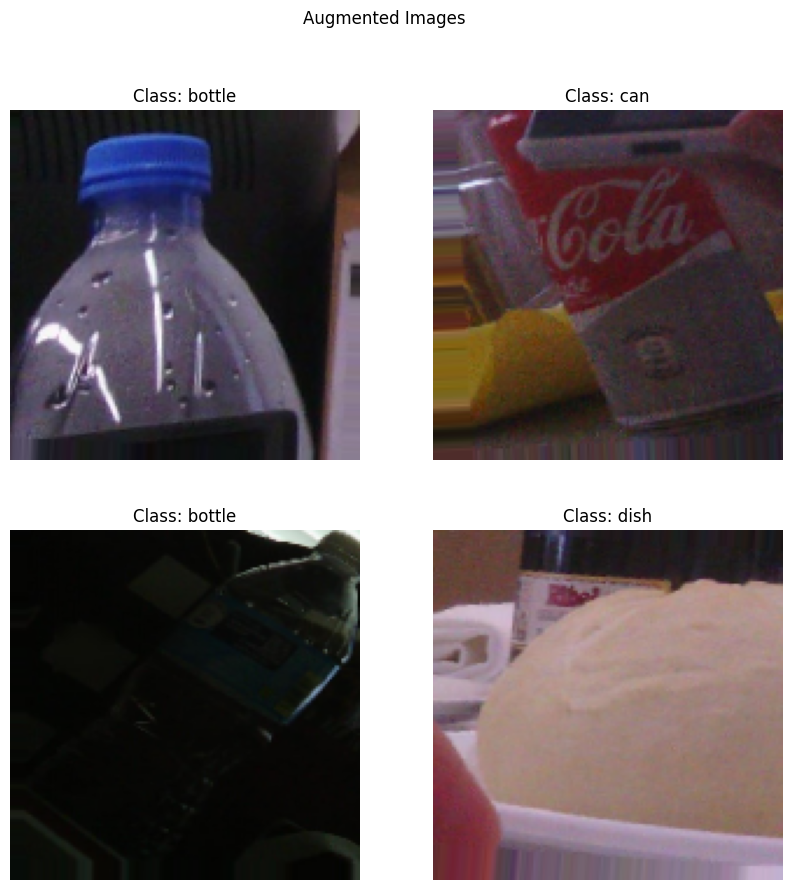

In [166]:
import matplotlib.pyplot as plt

x_batch, y_batch = next(train_gen)

num_rows = 2
num_cols = 2
num_images = num_rows * num_cols

plt.figure(figsize=(10, 10))
for i in range(num_images):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(x_batch[i])
    plt.title(f'Class: {id_to_name_mapping[int(y_batch[i])]}')
    plt.axis('off')
plt.suptitle('Augmented Images')
plt.show()


Fitting the model

In [196]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',  
    min_delta=0.001,     
    patience=5,          
    restore_best_weights=True
)

history = model.fit(
    train_gen,
    epochs=50,
    validation_data=val_gen,
    callbacks=[early_stopping]
)

Epoch 1/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 195s 1s/step - accuracy: 0.3039 - loss: 2.1078 - val_accuracy: 0.3721 - val_loss: 1.8997
Epoch 2/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - accuracy: 0.4157 - loss: 1.7729 - val_accuracy: 0.4551 - val_loss: 1.7722
Epoch 3/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.4563 - loss: 1.6185 - val_accuracy: 0.4814 - val_loss: 1.6880
Epoch 4/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 124s 930ms/step - accuracy: 0.5091 - loss: 1.4820 - val_accuracy: 0.5010 - val_loss: 1.6420
Epoch 5/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 128s 968ms/step - accuracy: 0.5627 - loss: 1.3607 - val_accuracy: 0.5127 - val_loss: 1.5829
Epoch 6/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 127s 963ms/step - accuracy: 0.6040 - loss: 1.2368 - val_accuracy: 0.5361 - val_loss: 1.5067
Epoch 7/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 132s 999ms/step - accuracy: 0.6389 - loss: 1.1707 - val_accuracy: 0.5264 - val_loss: 1.5265
Epoch 8/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 126s 954ms/step - accuracy: 0.6529 - loss: 1.

Saving the model

In [198]:
model.save('Food_Recognition_Model.keras')

Load the Model if needed

In [117]:
from tensorflow.keras.models import load_model

model = load_model('Food_Recognition_Model.keras')

Plotting the loss of the Model

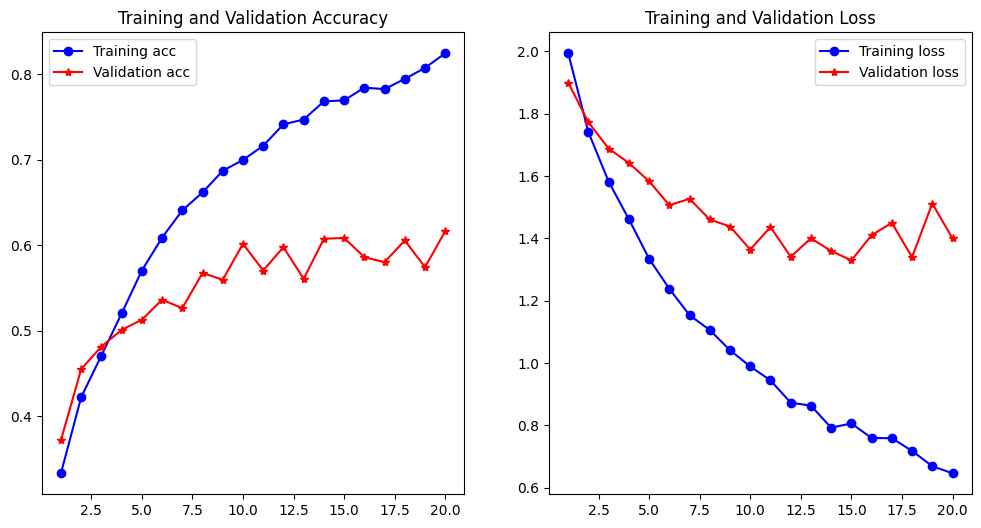

In [199]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training acc')
    plt.plot(epochs, val_acc, 'r*-', label='Validation acc')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'r*-', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.show()

plot_training_history(history)


Testing the model with new photos

In [200]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def prepare_image(image_path):
    img = load_img(image_path, target_size=(150, 150))  
    img_array = img_to_array(img) 
    img_array = img_array / 255.0  
    img_array = np.expand_dims(img_array, axis=0) 
    return img_array

def predict_image(model, image_path):
    img_array = prepare_image(image_path)
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1) 
    return predicted_class + 1 # predicted class is from 0-8, actual classes are 1-9

cup = 'download.jpg'
burger = 'download (1).jpg'
jar = 'images.jpg'
can = 'can.jpg'
predicted_class = predict_image(model, cup)
print(f"Predicted class: {predicted_class}")
predicted_class = predict_image(model, burger)
print(f"Predicted class: {predicted_class}")
predicted_class = predict_image(model, jar)
print(f"Predicted class: {predicted_class}")
predicted_class = predict_image(model, can)
print(f"Predicted class: {predicted_class}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step
Predicted class: [7]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
Predicted class: [3]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
Predicted class: [4]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Predicted class: [9]
